In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.dpi'] = 300

import sys
sys.path.append("../mpi_scripts/")
from io_utils import collect_results
import os
plt.style.use('../../styles/general.mplstyle')

In [2]:
from loss_utils import calculate_loss

In [3]:
from pypoptim.losses import RMSE

In [5]:
art_data = pd.read_csv('../../data/training/artificial_data.csv')

# Load results

In [4]:
case = "210721_131822"
dirname_results = '../../results/ina'
result = collect_results(case, dirname_results, dump_keys=['best', 'dump'])

In [5]:
config = result['config'].copy()
sol_best = result['sol_best'].copy()
phenotype_best = result['phenotype_best'].copy()
sol_best

ec_name  g_name     
common   c_p             1.346338
         c_m             1.494668
         a0_m            1.499968
         b0_m            0.187634
         delta_m         2.185517
         s_m             6.200830
         a0_h            0.672328
         b0_h            1.745078
         delta_h         3.155479
         s_h             5.667921
         a0_j            0.252400
         b0_j            0.360264
         delta_j         7.605523
         s_j             0.713832
         tau_j_const     9.605629
         R               0.944729
         R_f             0.605270
         g_max           0.427052
         g_leak          1.175670
         tau_z           0.738616
         v_half_m       18.879107
         v_half_h       84.606565
         k_m             7.848020
         k_h             5.418741
         x_c_comp        0.245941
         x_r_comp        1.053954
         alpha           0.746241
trace    v_off          -1.116026
Name: 0, dtype: float64

In [6]:
# names of genes
m_index = config['runtime']['m_index']
dump_genes = result['dump']['dump']['genes'].reshape((-1, len(m_index)))
n_organisms = config['runtime']['n_organisms']
n_generations = len(dump_genes) // n_organisms
# multiindex (generation, numb_of_organism) 
index = pd.MultiIndex.from_product([range(n_generations), range(n_organisms)],
                                   names=['epoch', 'org'])

dump_genes = pd.DataFrame(dump_genes, columns=m_index, index=index)

dump_loss = result['dump']['dump']['loss'].reshape((n_generations, config['runtime']['n_organisms']))

In [7]:
epochs = []
for k in range(n_generations):
    for l in range(n_organisms):
        epochs.append(k)

No handles with labels found to put in legend.


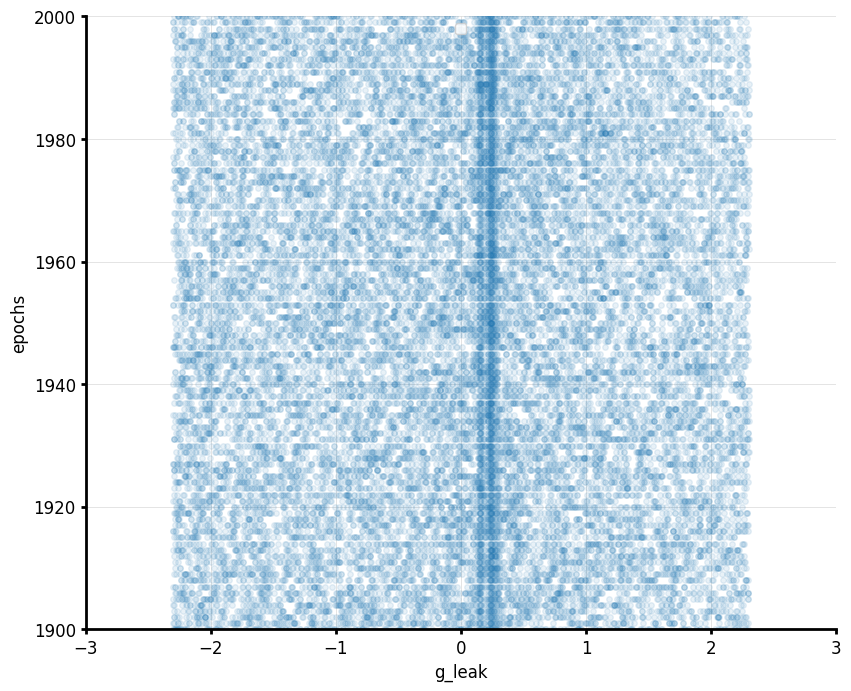

In [8]:
plt.plot(np.log(result['dump']['dump']['genes'][18::28]) , epochs, '.', alpha=0.1)
plt.plot()
plt.xlabel('g_leak')
plt.ylabel('epochs')
#plt.xlim(0,2)
plt.ylim(1900, 2000)
plt.legend()

No handles with labels found to put in legend.


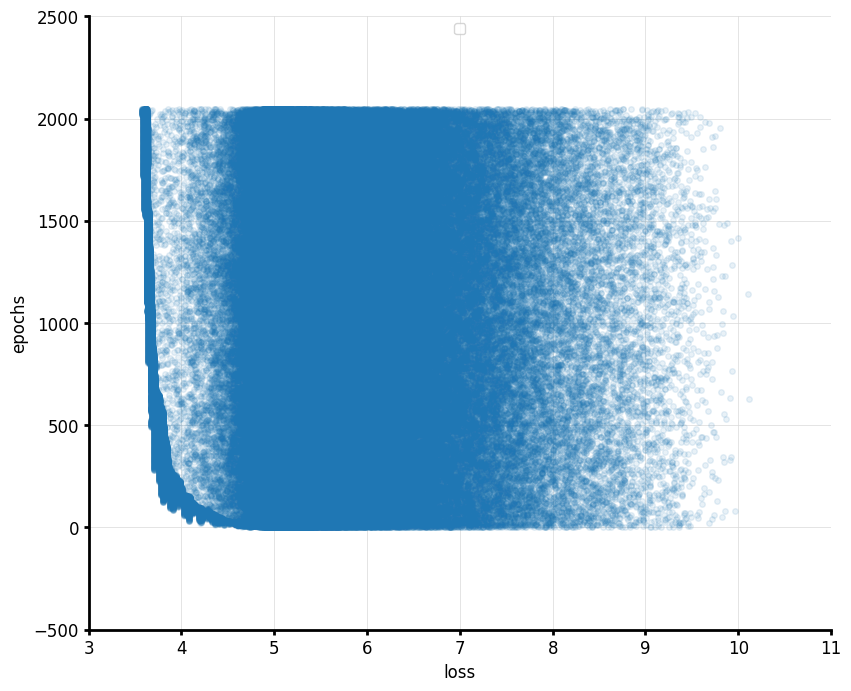

In [9]:
plt.plot(np.log(result['dump']['dump']['loss']) , epochs, '.', alpha=0.1)
plt.plot()
plt.xlabel('loss')
plt.ylabel('epochs')
#plt.xlim(3.5,3.8)
#plt.ylim(500, 600)
plt.legend()

In [9]:
from pypoptim.algorythm.ga import GA
from ina_model import InaModel
from solmodel import SolModel
from pypoptim.algorythm.ga.mutation import cauchy_mutation

In [10]:
import seaborn as sns

In [11]:
config

{'n_organisms': 256,
 'n_elites': 16,
 'n_generations': 5000,
 'output_folder_name': '../../results/ina/',
 'loss': 'RMSE',
 'columns_control': ['I_out'],
 'columns_model': ['I_out'],
 'column_stim_protocol': ['v'],
 'filename_so': '../../src/model_ctypes/ina/ina.so',
 'filename_legend_states': '../../src/model_ctypes/ina/legend_states.csv',
 'filename_legend_constants': '../../src/model_ctypes/ina/legend_constants.csv',
 'filename_legend_algebraic': '../../src/model_ctypes/ina/legend_algebraic.csv',
 'filename_protocol': '../../data/protocols/protocol_trace.csv',
 'filename_initial_state_protocol': '../../data/protocols/protocol_initial_state.csv',
 'experimental_conditions': {'common': {'params': {'c_p': {'bounds': [0.1, 10],
     'gamma': 0.15,
     'is_multiplier': True},
    'c_m': {'bounds': [0.1, 10], 'gamma': 0.15, 'is_multiplier': True},
    'a0_m': {'bounds': [0.1, 10], 'gamma': 0.15, 'is_multiplier': True},
    'b0_m': {'bounds': [0.1, 10], 'gamma': 0.15, 'is_multiplier': Tr

In [12]:
filename_so = "../../src/model_ctypes/ina/ina.so"
# filename_so = config['runtime']['filename_so_abs']
model = InaModel(filename_so)
SolModel.model = model
SolModel.config = config
#config['runtime']['gammas']+=1


In [93]:
dirname = '../../src/model_ctypes/ina/'

C = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')
column_names = C.T.columns[:-2]

In [114]:

gammas = np.zeros_like(config['runtime']['gammas'])
gammas+=1
ga_optim = GA(SolModel,
              config['runtime']['bounds'],
              #config['runtime']['gammas'],
              gammas,
              config['runtime']['mask_multipliers'],
              crossover_rate=0
              )
sol = ga_optim.generate_solution()
print('gammas = ',gammas)

genes_initial = sol.x
genes_transformed = ga_optim._transform_genes(genes_initial)
bounds_transformed = ga_optim._bounds_transformed

result = []
for _ in range(25600):
    genes_mutated = cauchy_mutation(genes=genes_transformed,
                                bounds=bounds_transformed, 
                                gamma = gammas,
                                        )

    genes = ga_optim._transform_genes_back(np.asfarray(genes_mutated))
    result.append(genes)
result = pd.DataFrame(result, columns=column_names)

gammas =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [115]:
gammas1 = np.zeros_like(config['runtime']['gammas'])
gammas1+=1
gammas1[:20]-=0.5

ga_optim1 = GA(SolModel,
              config['runtime']['bounds'],
              #config['runtime']['gammas'],
              gammas1,
              config['runtime']['mask_multipliers'],
              crossover_rate=0
              )
sol1 = ga_optim1.generate_solution()
print('gammas = ',gammas1)

genes_initial1 = sol1.x
genes_transformed1 = ga_optim._transform_genes(genes_initial1)
bounds_transformed1 = ga_optim._bounds_transformed

result1 = []
for _ in range(25600):
    genes_mutated1 = cauchy_mutation(genes=genes_transformed1,
                                bounds=bounds_transformed1, 
                                gamma = gammas1,
                                        )

    genes1 = ga_optim._transform_genes_back(np.asfarray(genes_mutated1))
    result1.append(genes1)
result1 = pd.DataFrame(result1, columns=column_names)

gammas =  [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 1.  1.  1.  1.  1.  1.  1.  1. ]


/home/nik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

/home/nik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

/home/nik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

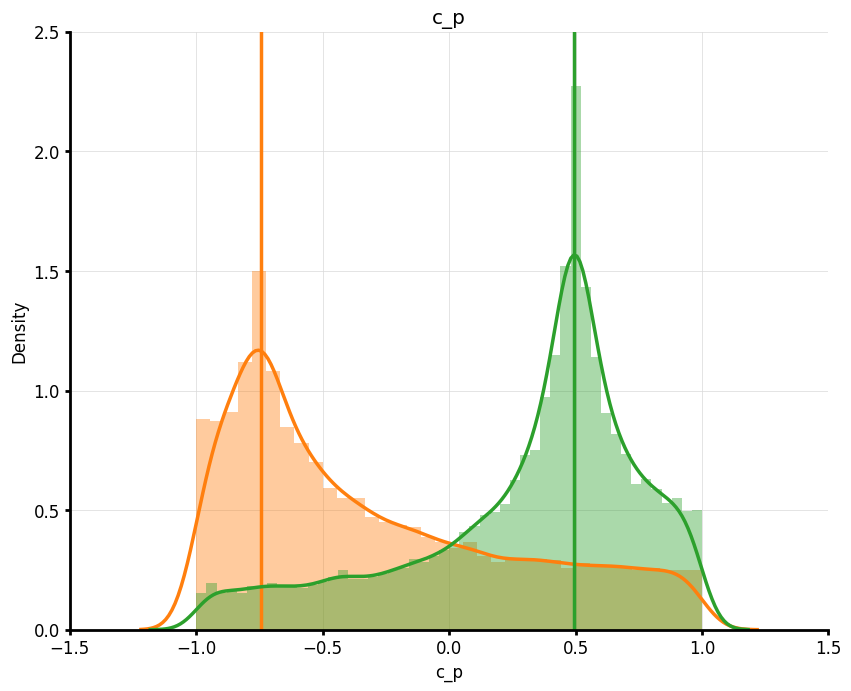

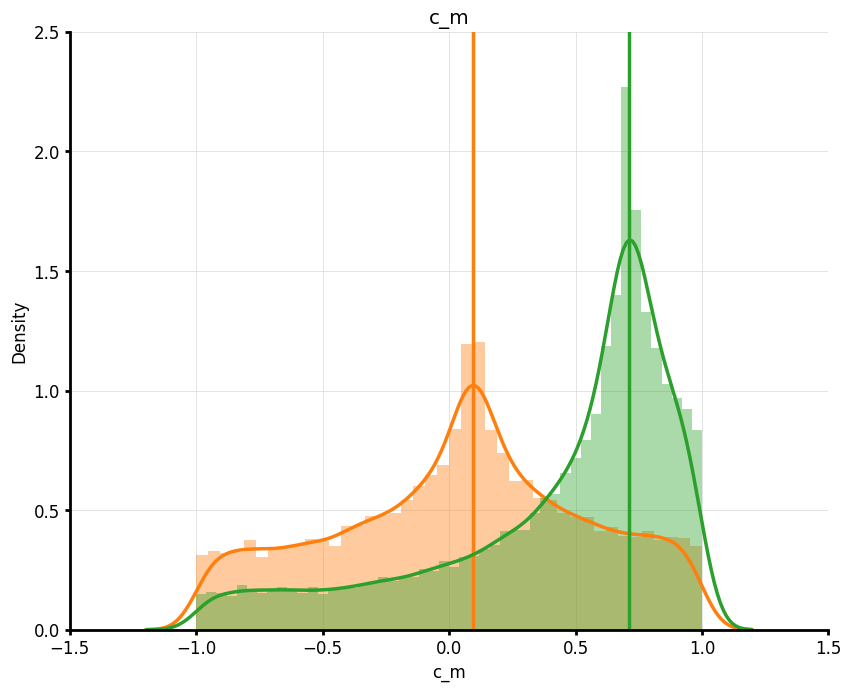

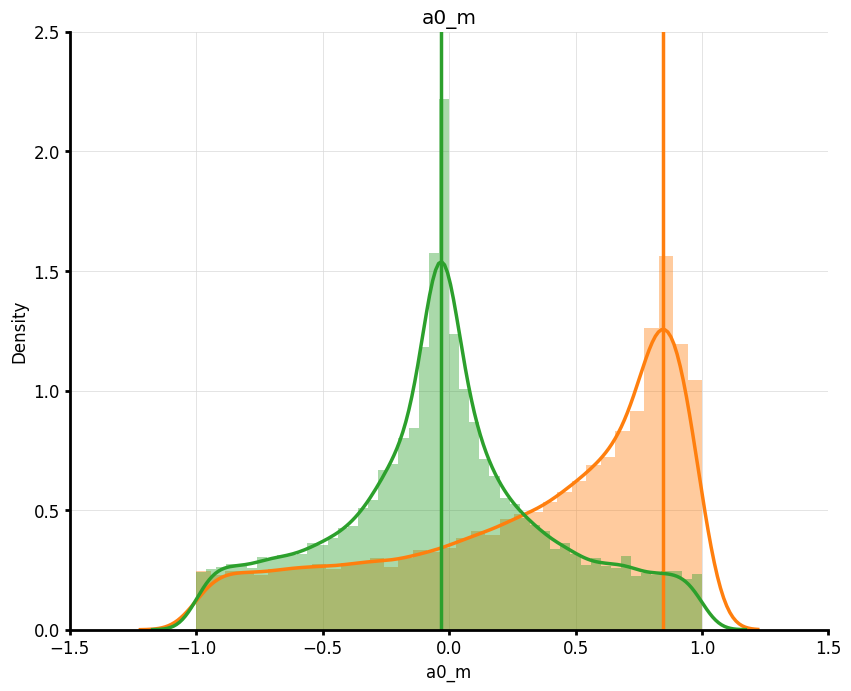

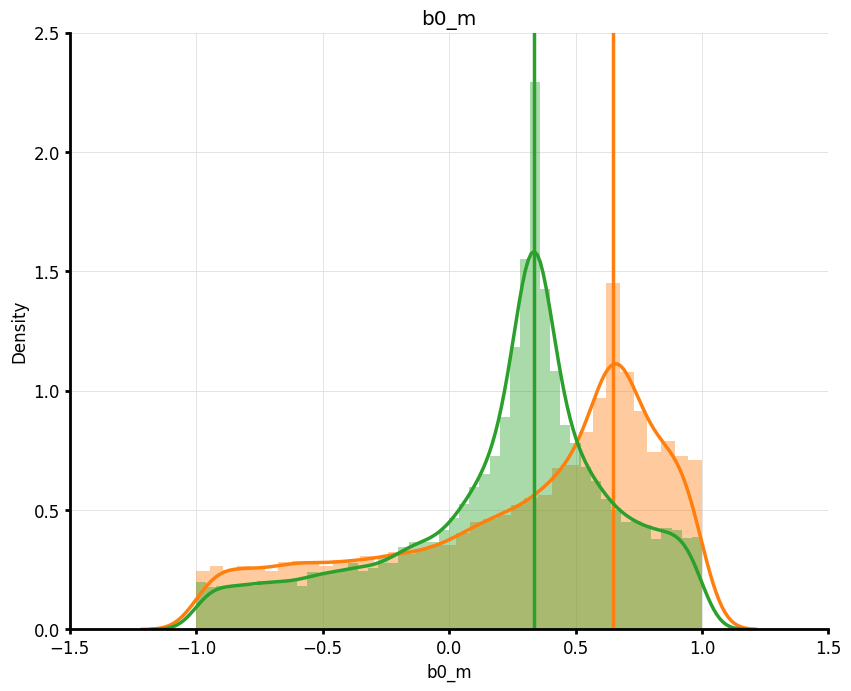

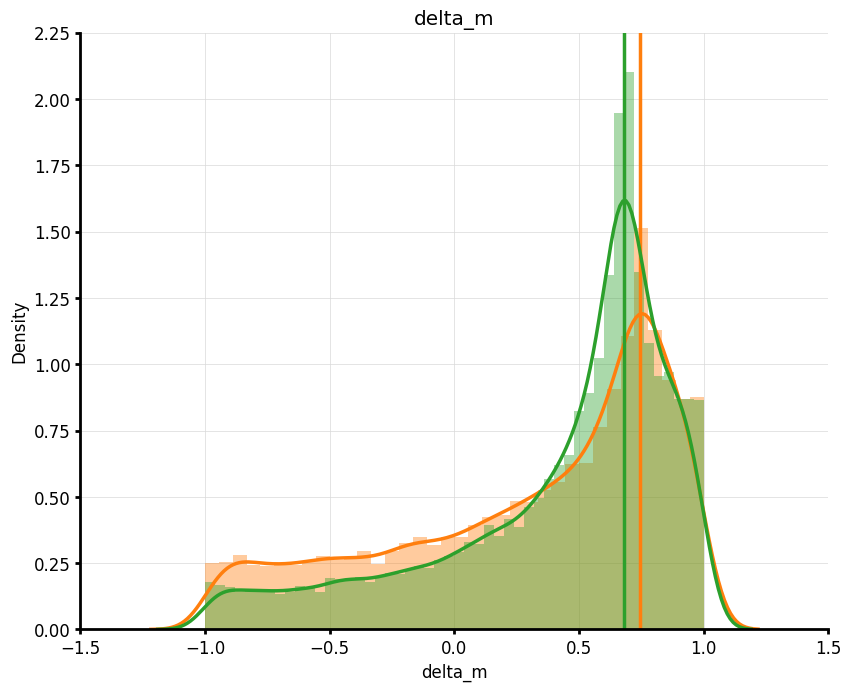

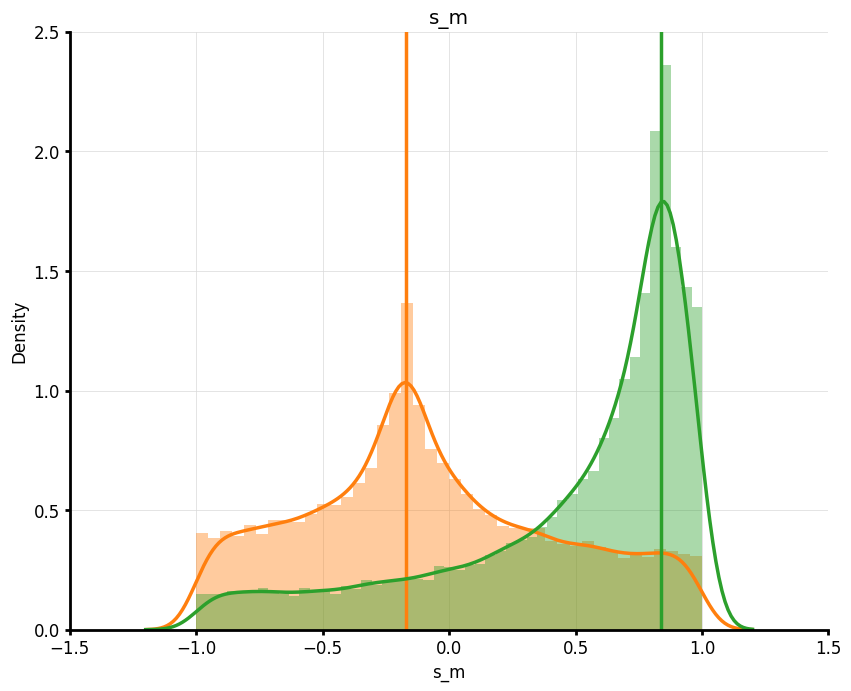

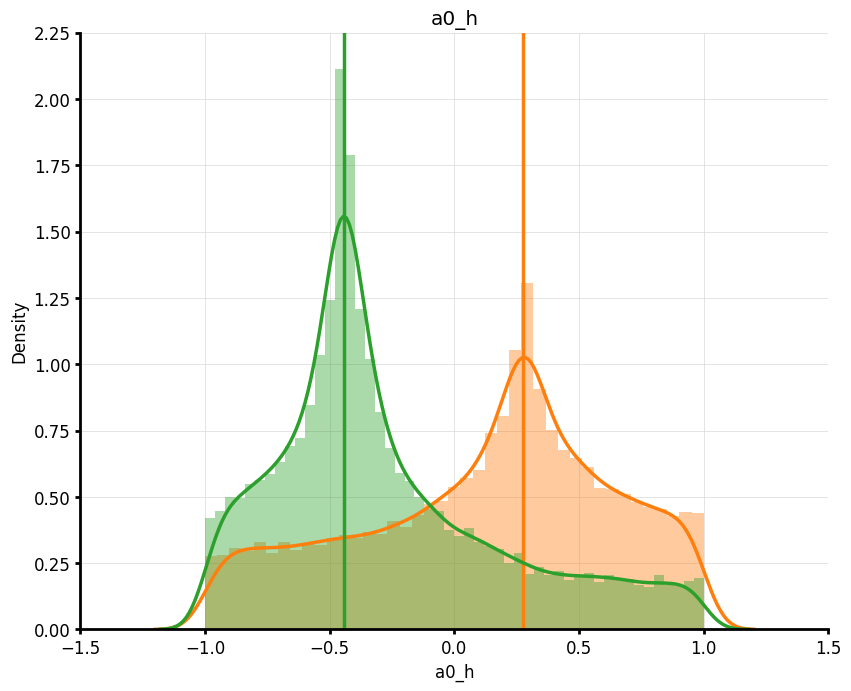

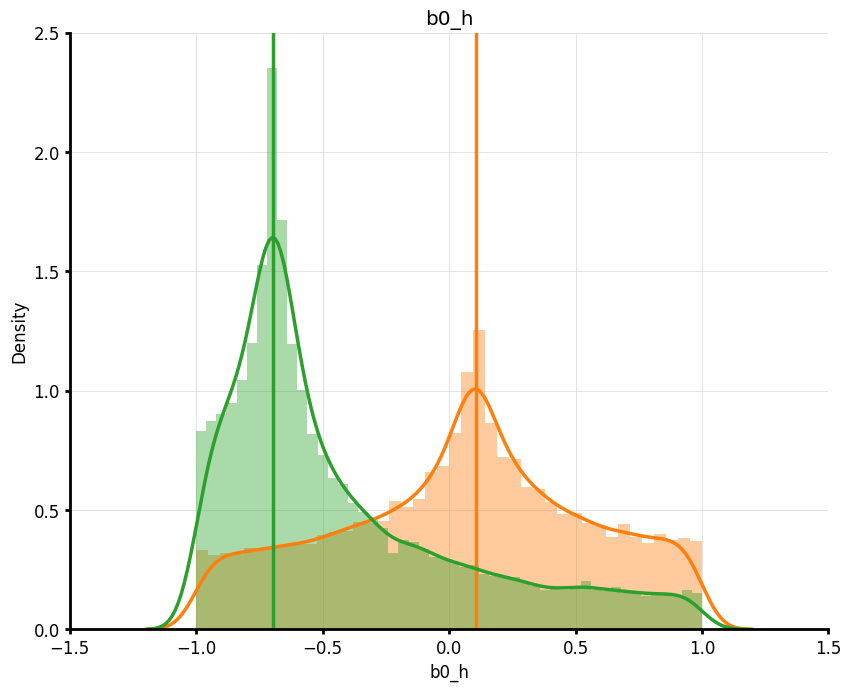

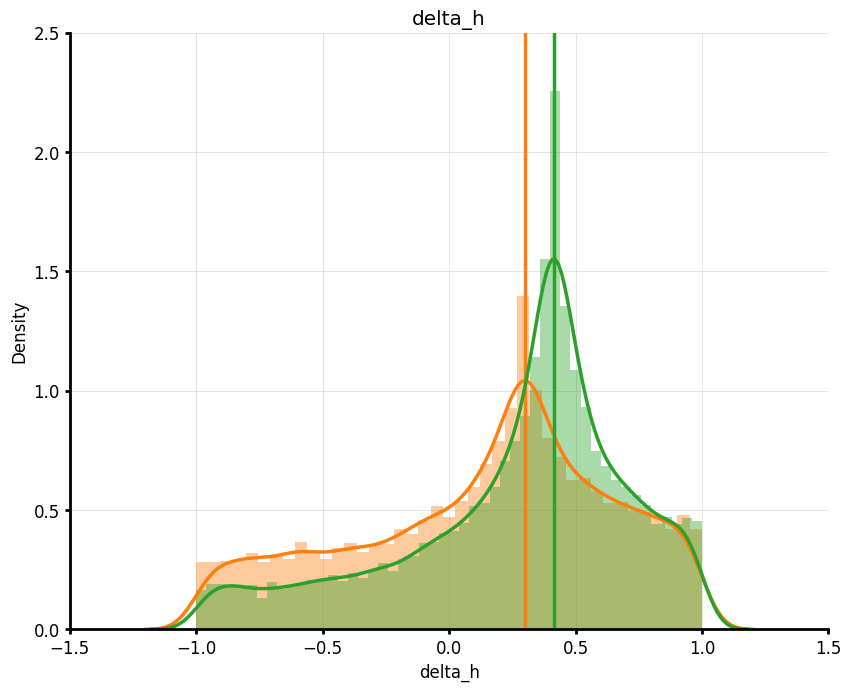

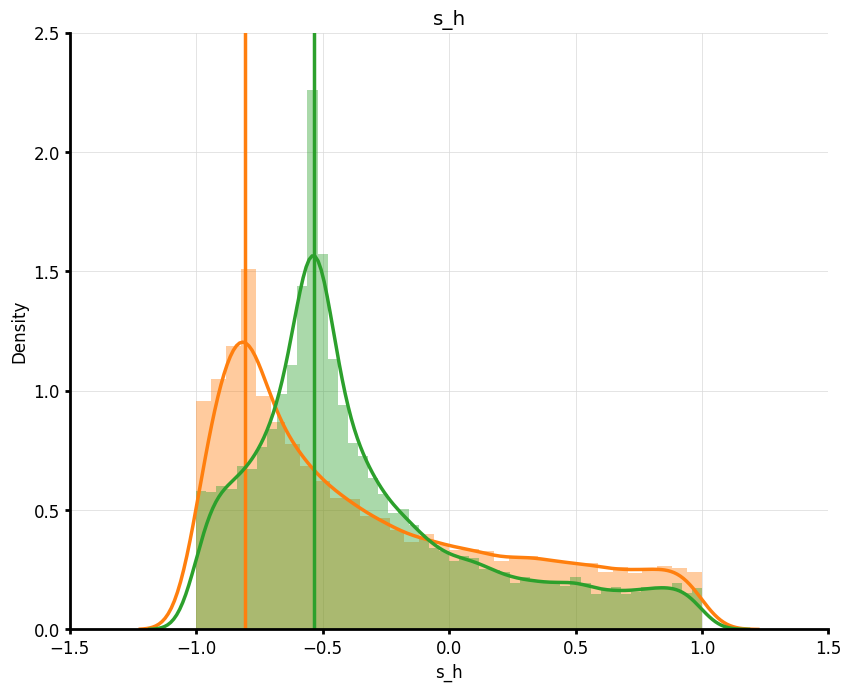

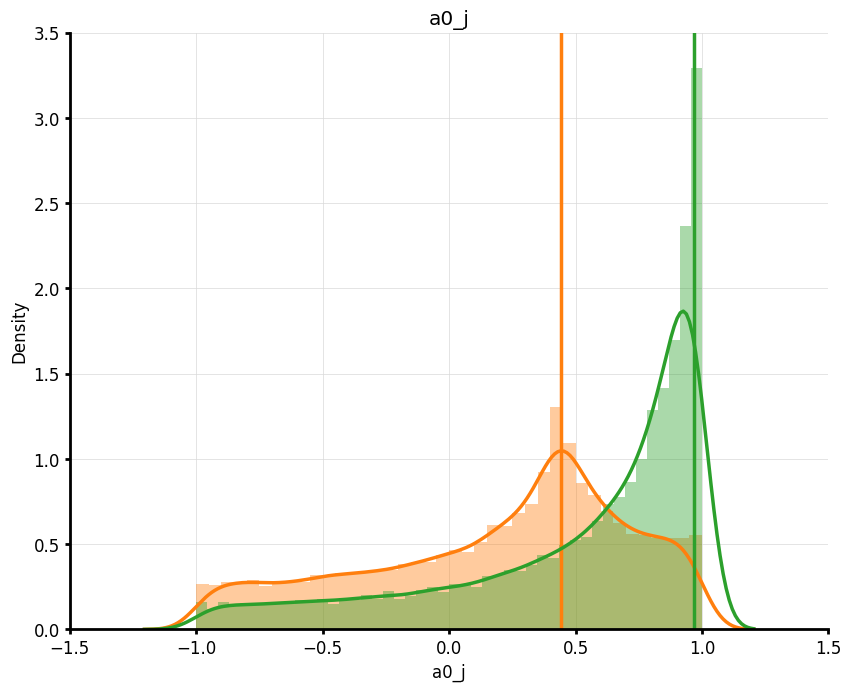

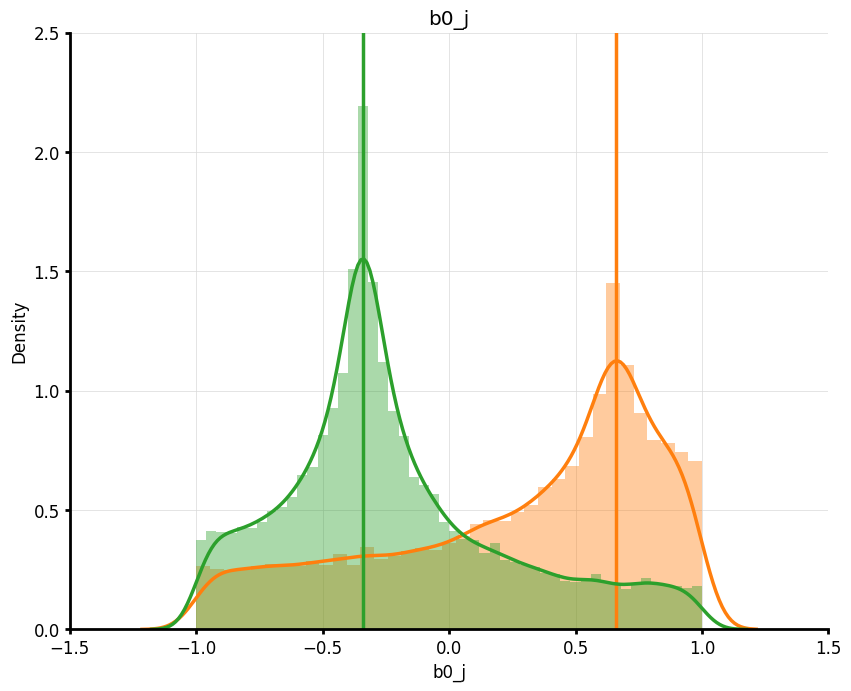

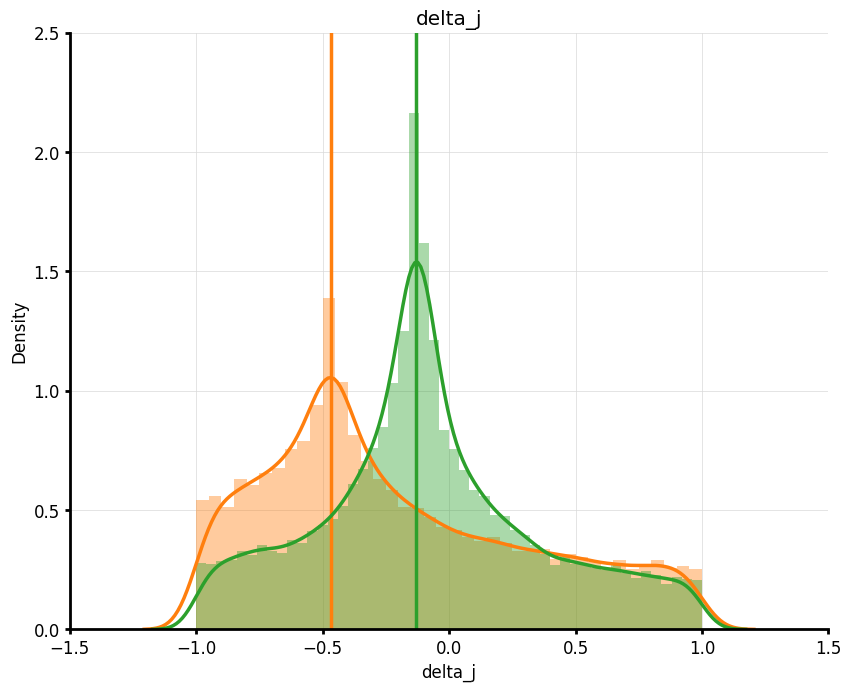

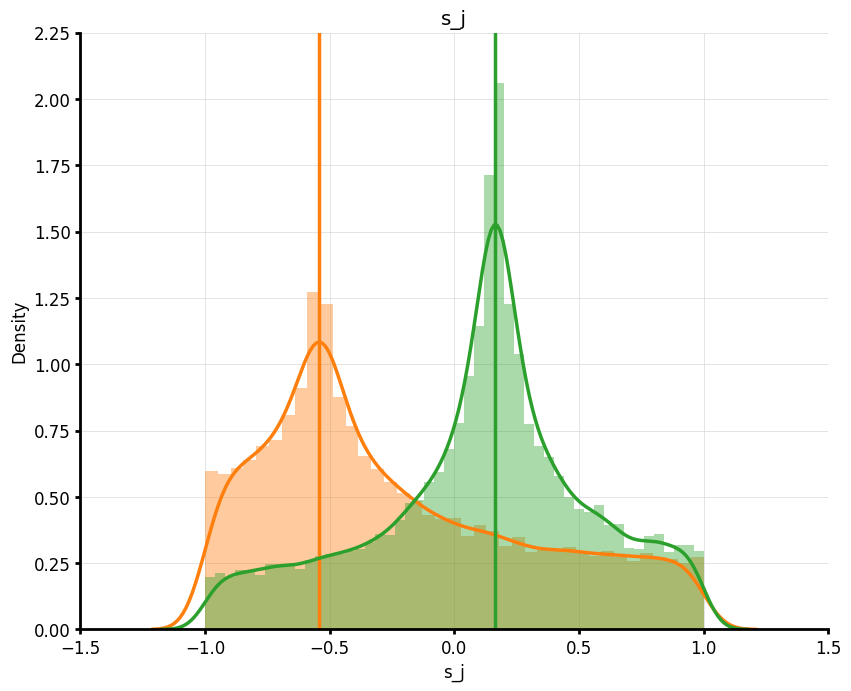

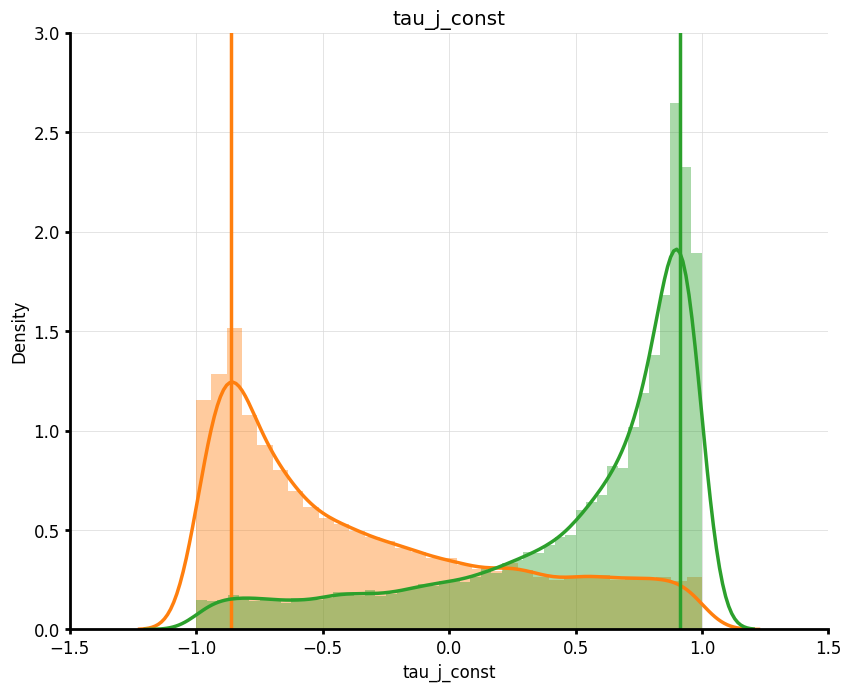

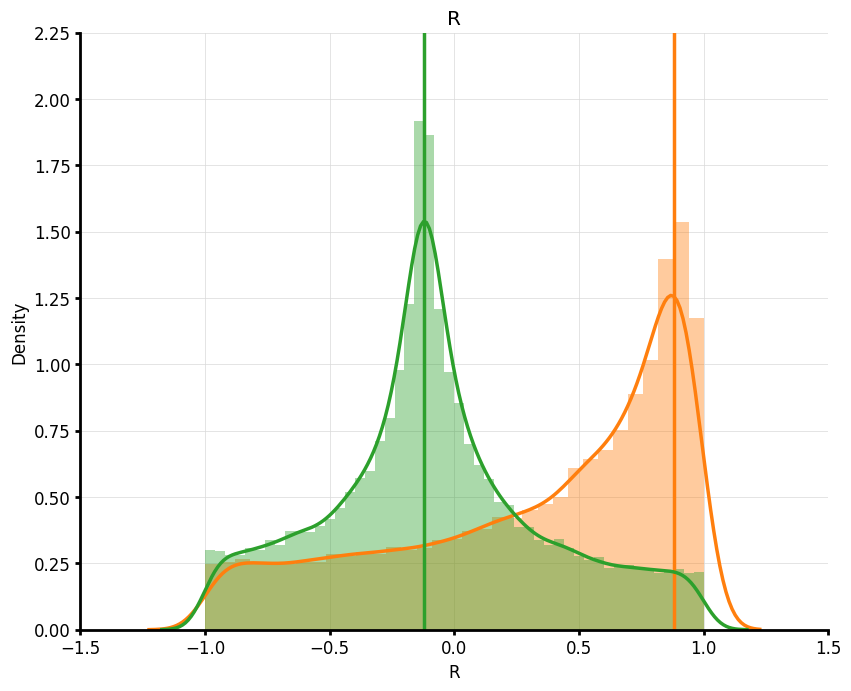

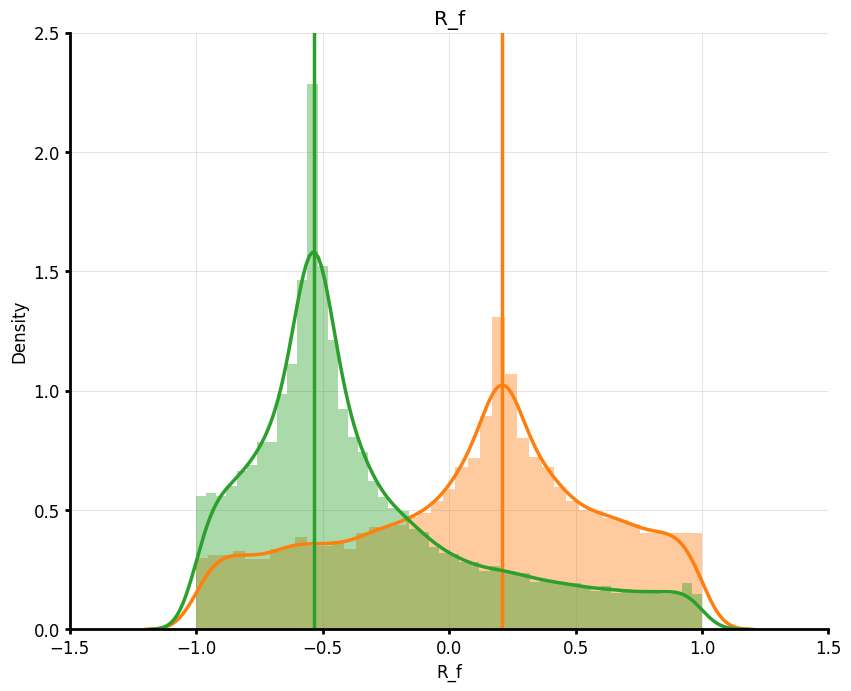

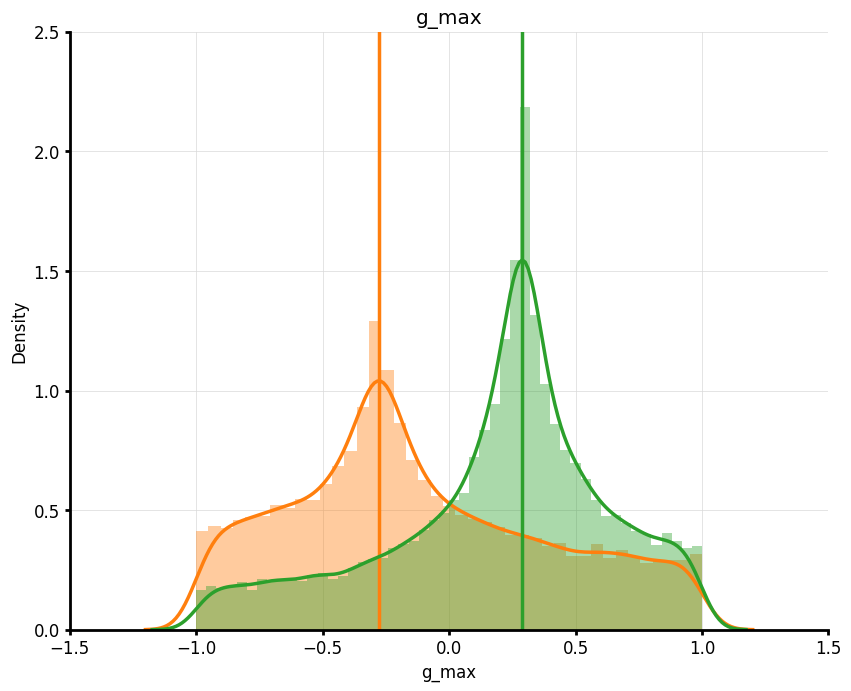

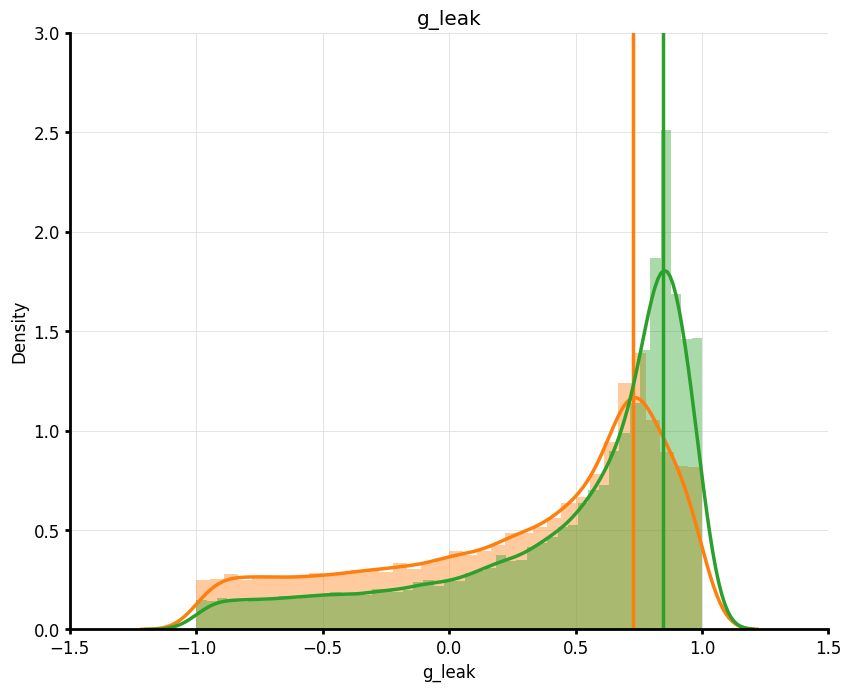

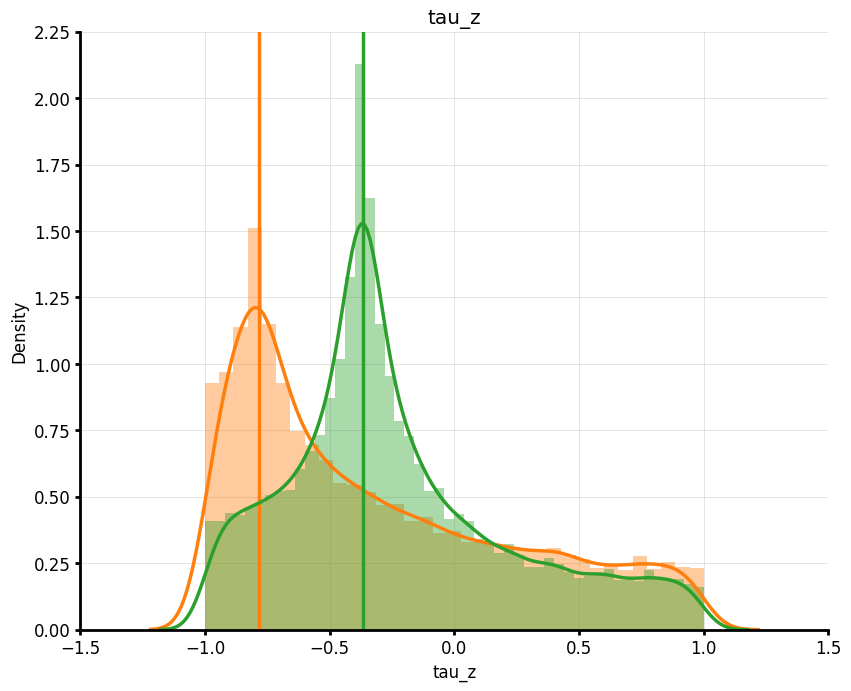

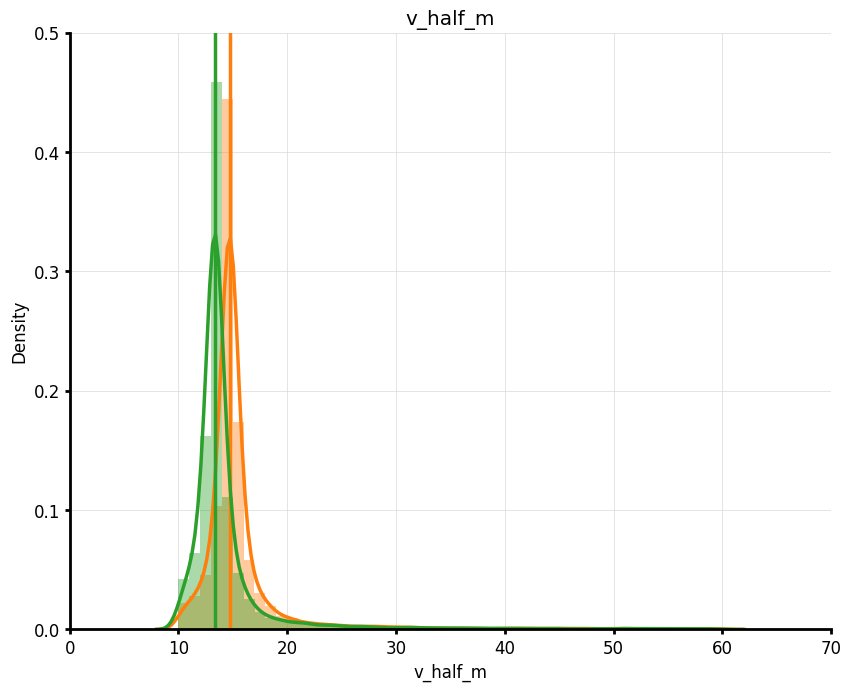

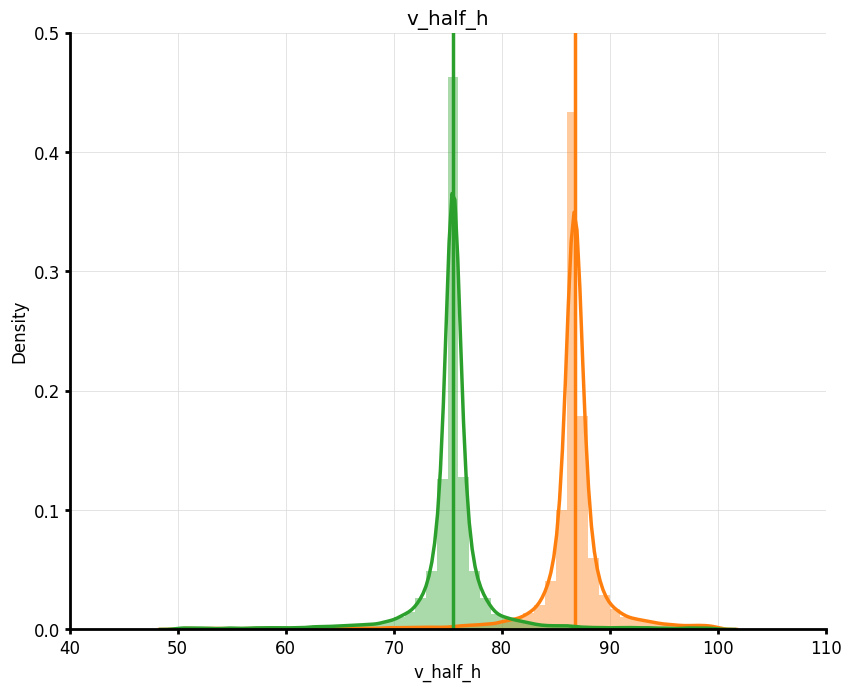

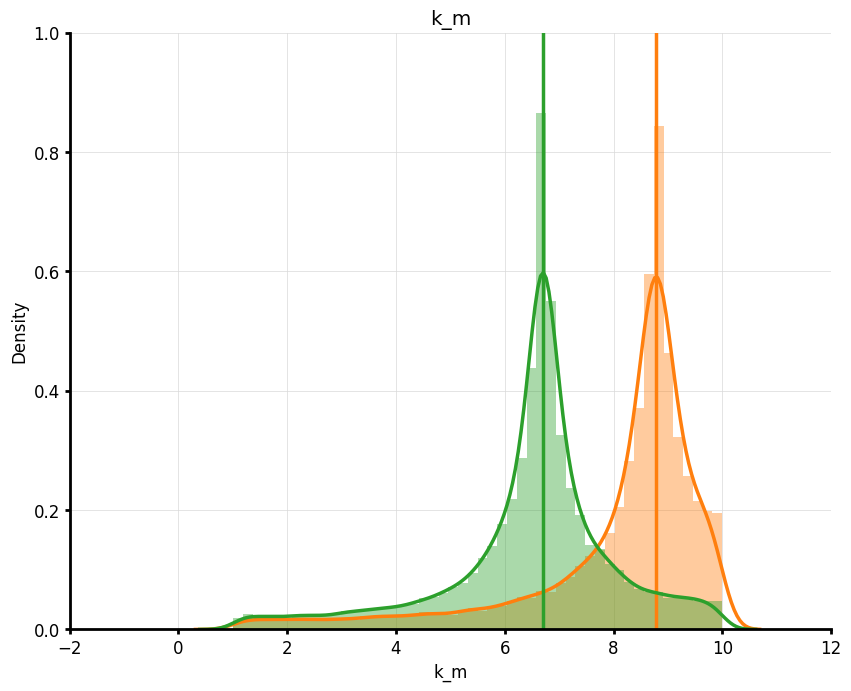

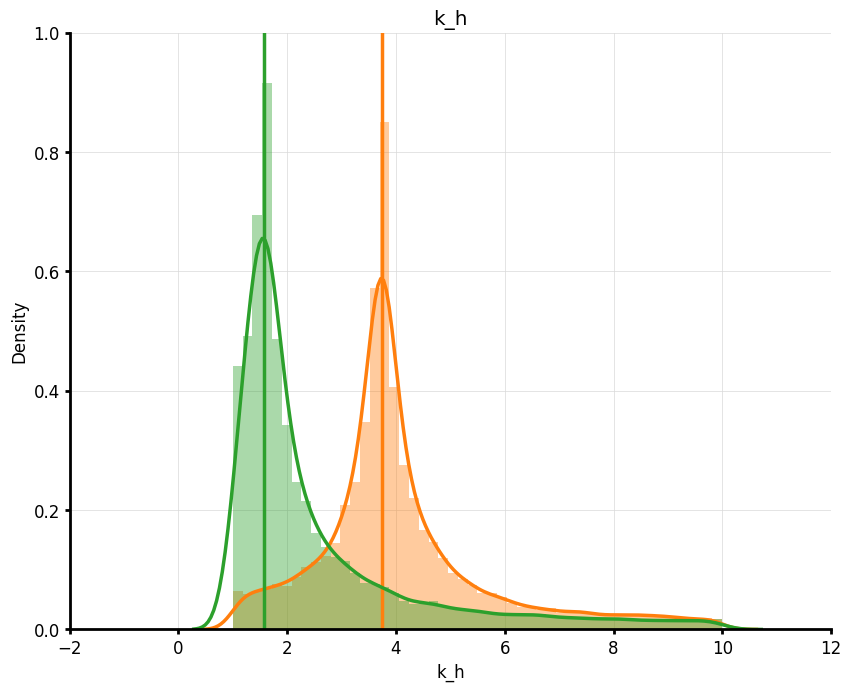

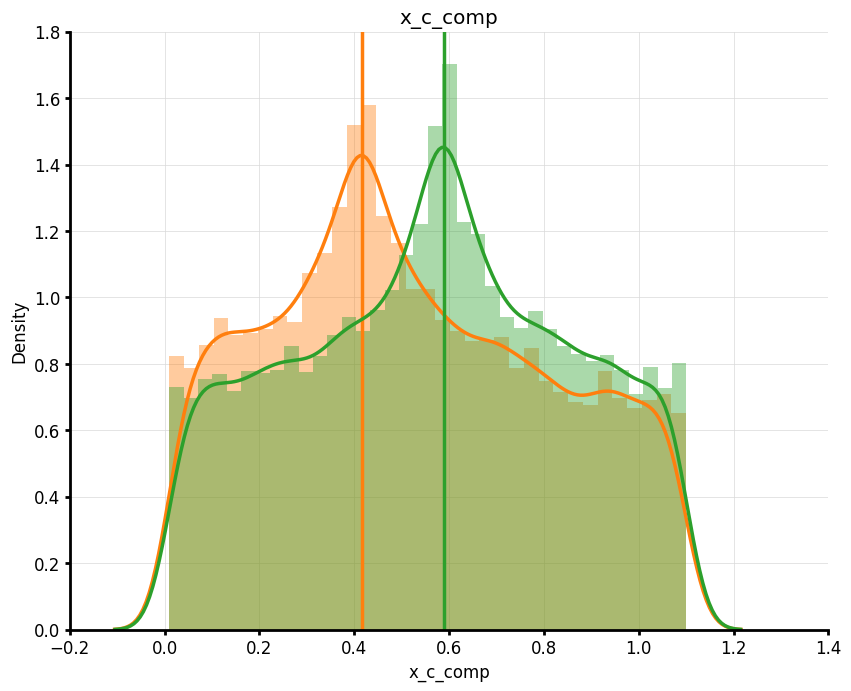

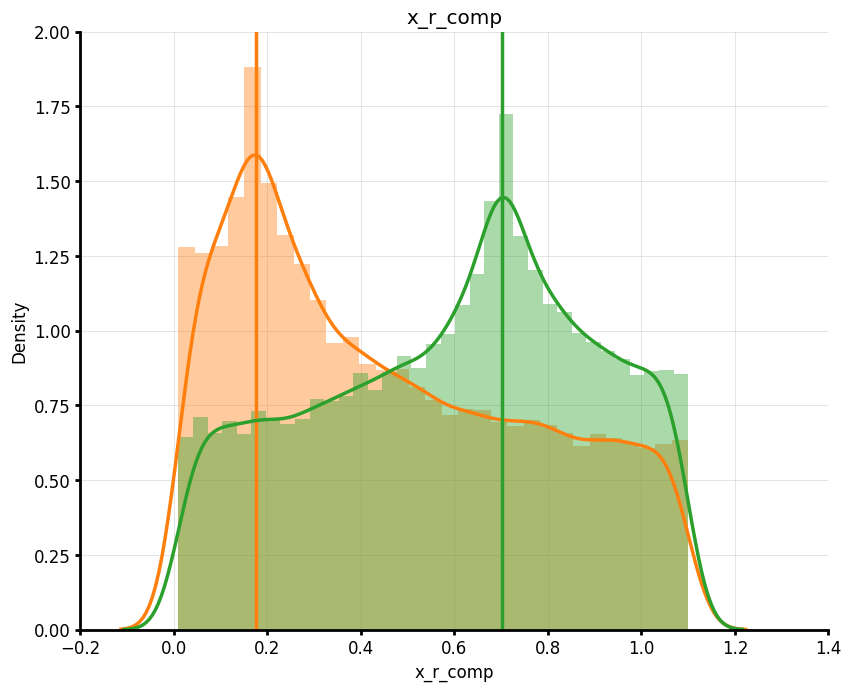

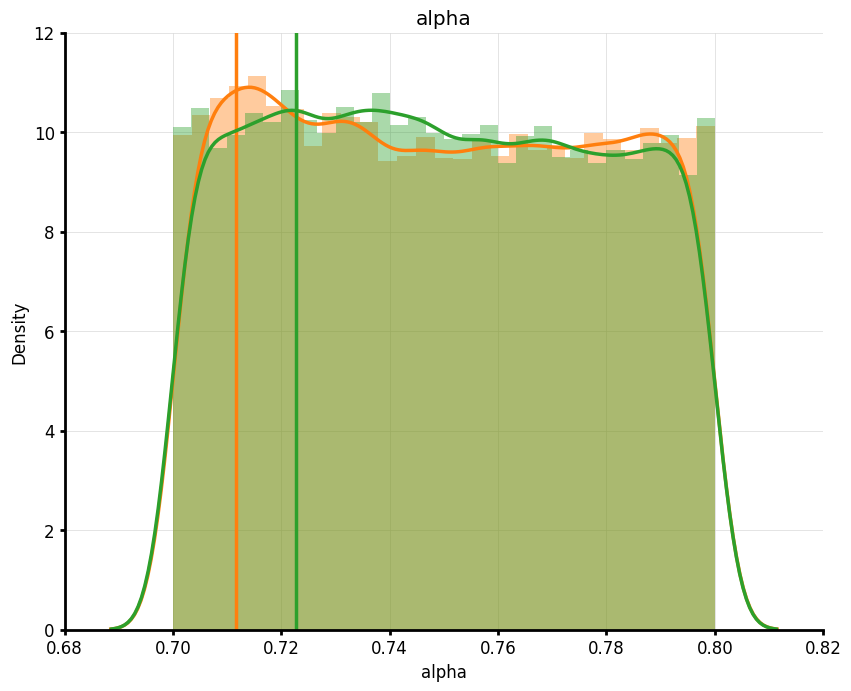

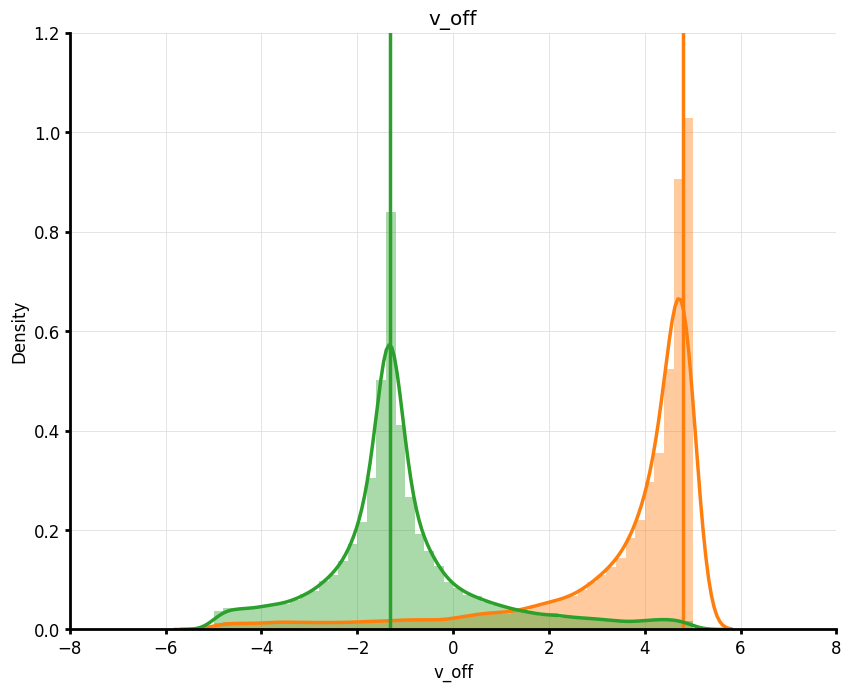

In [116]:
for k in range(20):
    plt.figure()
    sns.distplot(np.log10(result[column_names[k]]), color='C1')
    plt.axvline(np.log10(genes_initial[k]), color='C1')
    
    sns.distplot(np.log10(result1[column_names[k]]), color='C2')
    plt.axvline(np.log10(genes_initial1[k]), color='C2')
    plt.title(column_names[k])

for k in range(20,28):
    plt.figure()
    sns.distplot(result[column_names[k]], color='C1')
    plt.axvline(genes_initial[k], color='C1')
    
    sns.distplot(result1[column_names[k]],color='C2')
    plt.axvline(genes_initial1[k], color='C2')
    plt.title(column_names[k])

<ipython-input-17-6beea4687118>:1: RuntimeWarning: invalid value encountered in log10
  sns.distplot(np.log10(result))
/home/nik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nik/.local/lib/python3.8/site-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/nik/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nik/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<AxesSubplot:>

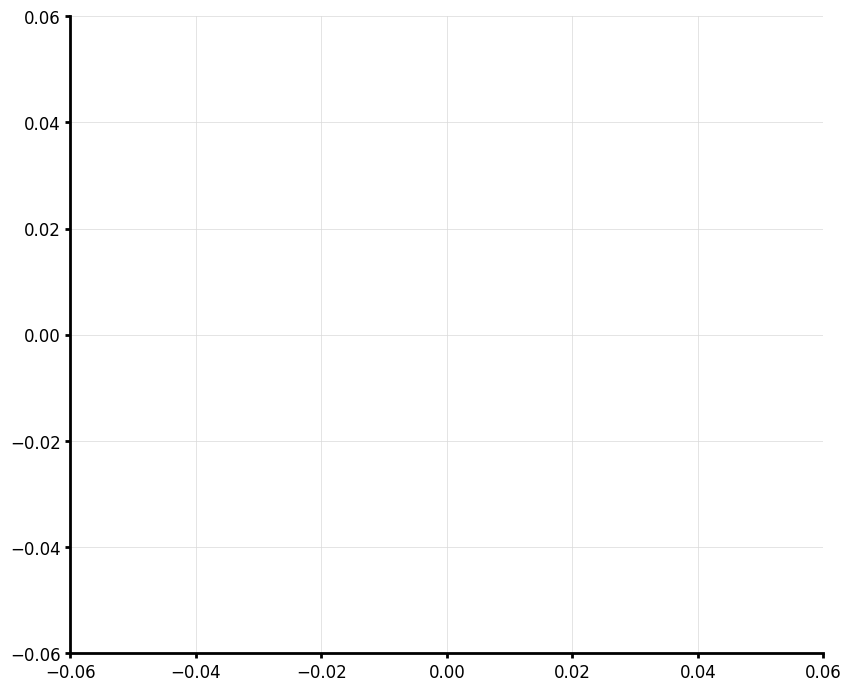

In [17]:
sns.distplot(np.log10(result))

In [14]:
generations = np.arange(n_generations)

No handles with labels found to put in legend.


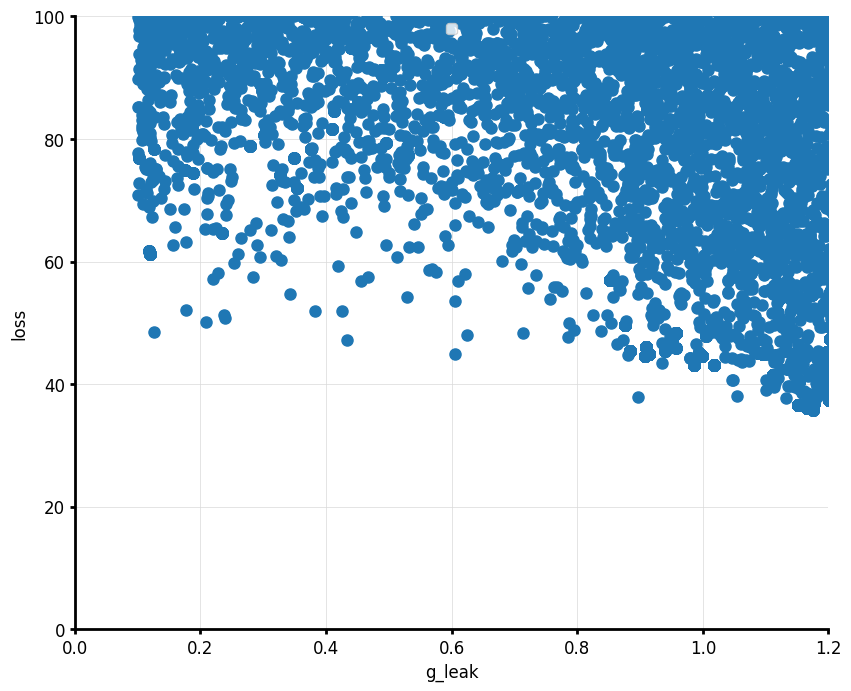

In [28]:
plt.scatter(result['dump']['dump']['genes'][18::28],result['dump']['dump']['loss'] )
plt.xlabel('g_leak')
plt.ylabel('loss')
plt.xlim(0, 1.2)
plt.ylim(0,100)
plt.legend()

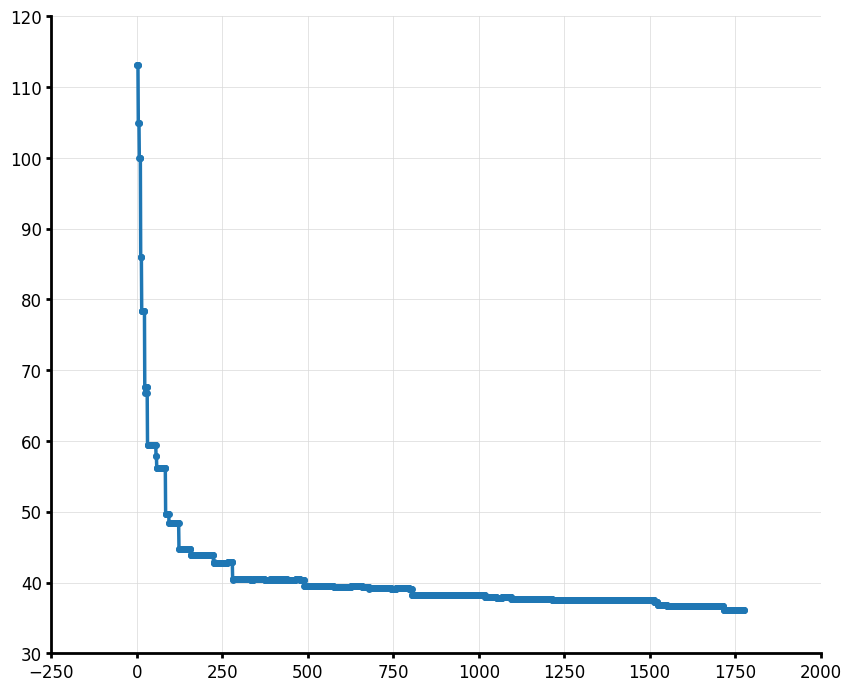

In [29]:
loss = result['dump']['best']['loss']
plt.plot(loss, '.-')

In [ ]:
result = collect_results(case, dirname_results, dump_keys=['best', 'dump'])

In [ ]:
dump_genes = pd.DataFrame(result['dump']['best']['genes'].reshape(-1, len(sol_best)),
                          columns=config['runtime']['m_index'])
dump_genes

In [ ]:
plt.scatter(dump_genes['common']['g_leak'],loss)
plt.ylabel('loss')
plt.xlabel('g_leak')
plt.legend()

# Recreate solution

In [15]:
sys.path.append('src/model')
from ina_model import InaModel
from solmodel import SolModel

In [16]:
C.T.columns


Index(['c_p', 'c_m', 'a0_m', 'b0_m', 'delta_m', 's_m', 'a0_h', 'b0_h',
       'delta_h', 's_h', 'a0_j', 'b0_j', 'delta_j', 's_j', 'tau_j_const', 'R',
       'R_f', 'g_max', 'g_leak', 'tau_z', 'v_half_m', 'v_half_h', 'k_m', 'k_h',
       'x_c_comp', 'x_r_comp', 'alpha', 'v_off', 'v_rev', 'v_c'],
      dtype='object', name='name')

In [17]:
sol_best['common']['g_leak'] =1

In [18]:
sol_best1 = sol_best.copy()
sol_best1

ec_name  g_name     
common   c_p             1.346338
         c_m             1.494668
         a0_m            1.499968
         b0_m            0.187634
         delta_m         2.185517
         s_m             6.200830
         a0_h            0.672328
         b0_h            1.745078
         delta_h         3.155479
         s_h             5.667921
         a0_j            0.252400
         b0_j            0.360264
         delta_j         7.605523
         s_j             0.713832
         tau_j_const     9.605629
         R               0.944729
         R_f             0.605270
         g_max           0.427052
         g_leak          1.000000
         tau_z           0.738616
         v_half_m       18.879107
         v_half_h       84.606565
         k_m             7.848020
         k_h             5.418741
         x_c_comp        0.245941
         x_r_comp        1.053954
         alpha           0.746241
trace    v_off          -1.116026
Name: 0, dtype: float64

In [27]:
filename_so = "../../src/model_ctypes/ina/ina.so"
model = InaModel(filename_so)

SolModel.model = model
SolModel.config = config.copy()

sol = SolModel(x=sol_best1)

In [28]:
sol.update()

In [29]:
sol

Solution = {
    x    = [ 1.34633828  1.49466779  1.4999685   0.18763356  2.1855166   6.2008298
  0.67232776  1.74507783  3.15547882  5.66792144  0.2523999   0.36026433
  7.60552299  0.71383154  9.60562864  0.94472885  0.60526993  0.42705179
  1.          0.73861598 18.87910666 84.60656491  7.84802032  5.4187408
  0.2459412   1.05395393  0.74624064 -1.11602572],
    y    = 37.85671042519609,
    data = {'phenotype': {'trace': name   v_comp   v_p        v_m         m         h         j      I_out
0       -80.0 -80.0 -80.206328  0.000404  0.307456  0.307456 -38.598953
1       -80.0 -80.0 -80.206328  0.000404  0.307456  0.307456 -38.598953
2       -80.0 -80.0 -80.206328  0.000404  0.307456  0.307456 -38.598953
3       -80.0 -80.0 -80.206328  0.000404  0.307456  0.307456 -38.598953
4       -80.0 -80.0 -80.206328  0.000404  0.307456  0.307456 -38.598953
...       ...   ...        ...       ...       ...       ...        ...
99995   -80.0 -80.0 -80.206328  0.000404  0.307228  0.306493 -38.5

In [31]:
I_best = sol['phenotype']['trace']['I_out']

In [32]:
I = config['experimental_conditions']['trace']['phenotype']['I_out']
RMSE(I_best, I)

37.85671042519609

In [33]:
I = config['experimental_conditions']['trace']['phenotype']['I_out']
RMSE(I_best, I)

37.85671042519609

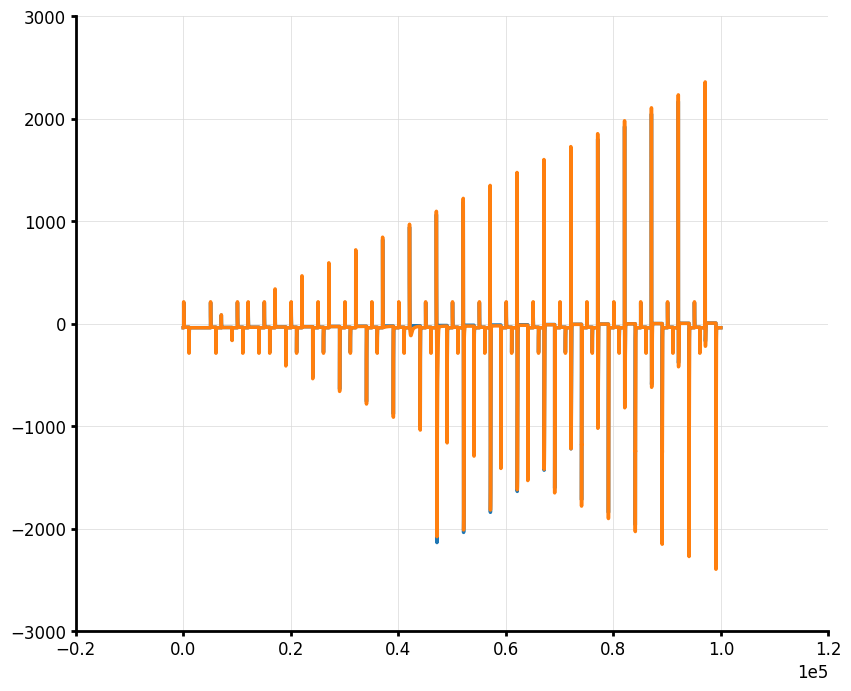

In [35]:
plt.plot(sol['phenotype']['trace']['I_out'])
plt.plot(art_data.I_out)

<ipython-input-86-eec4793ef5e1>:43: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


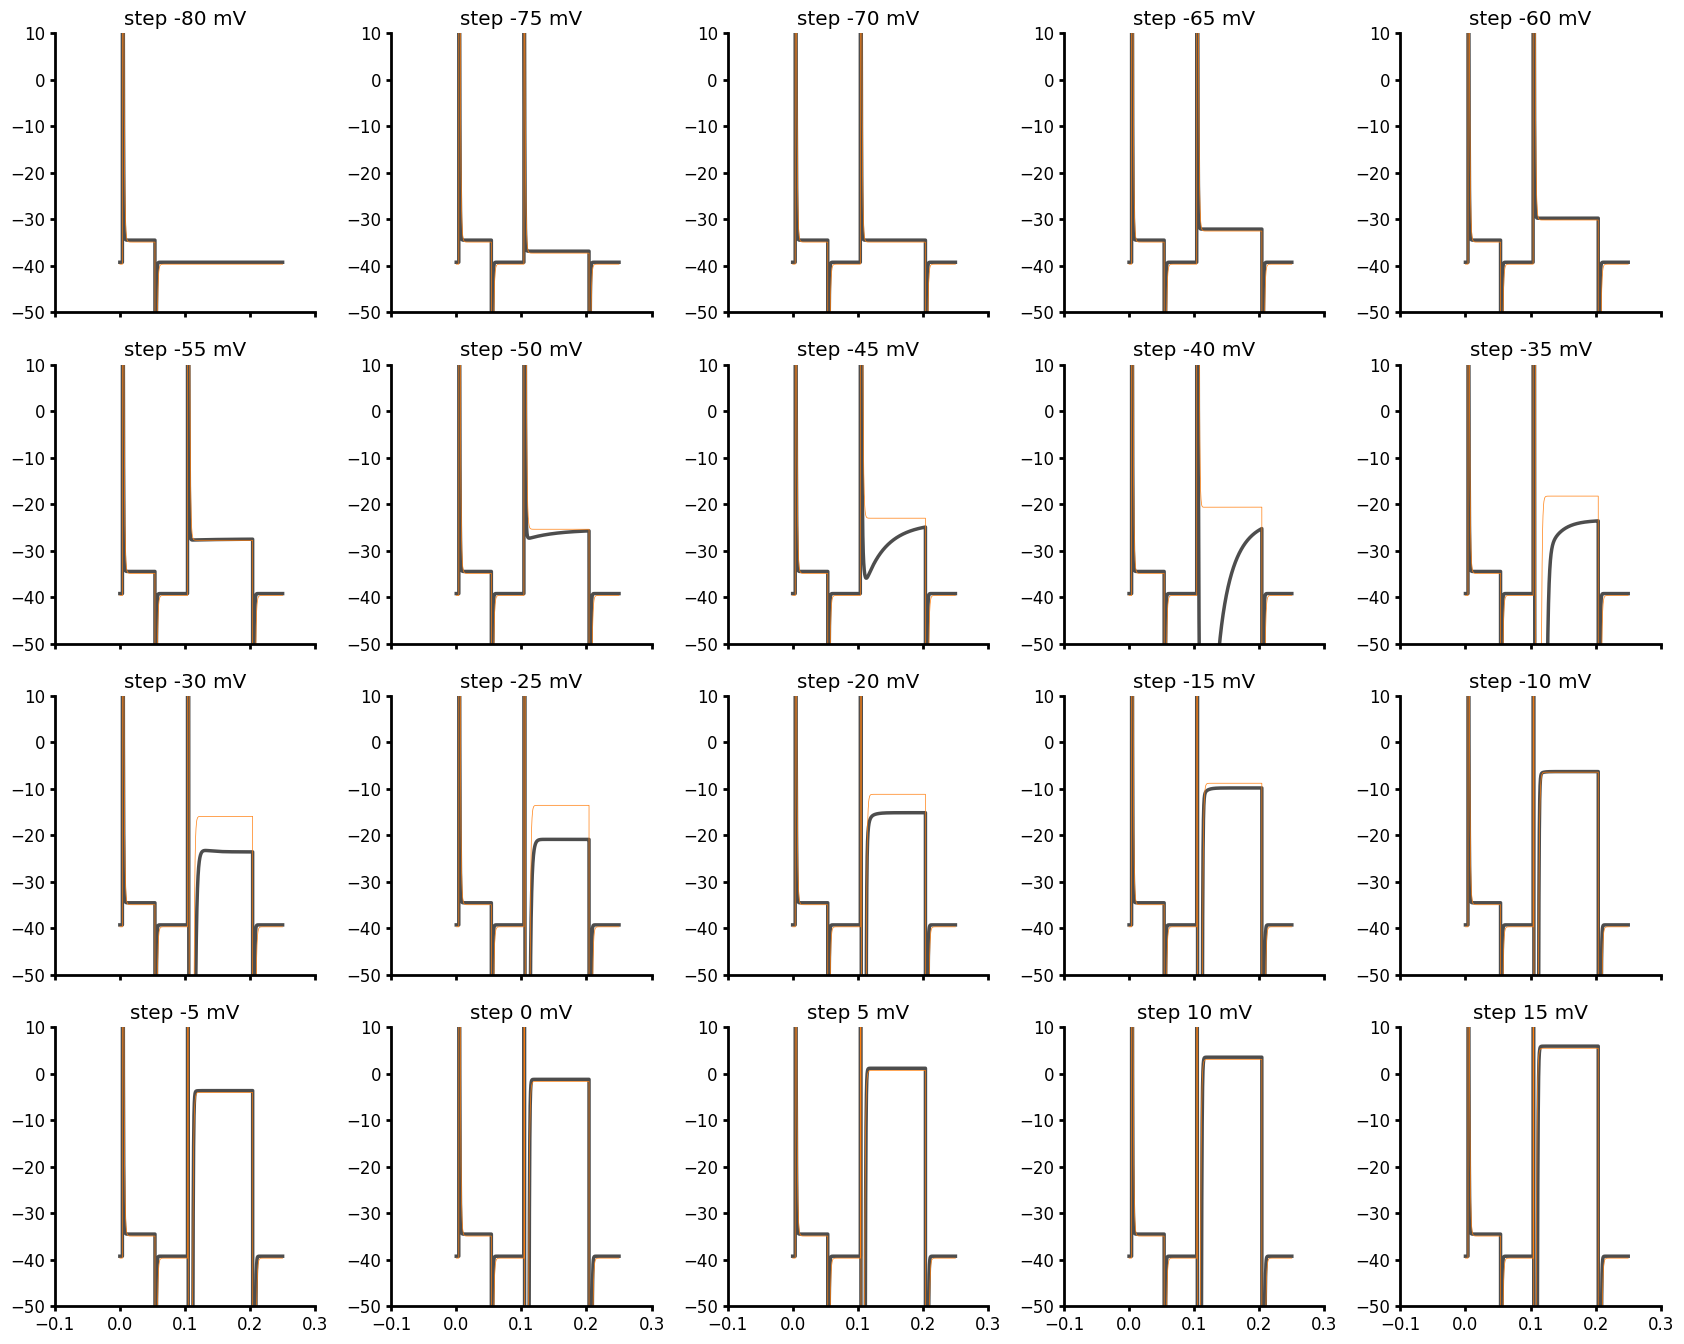

In [86]:
    I_out = sol['phenotype']['trace']['I_out']
    real_data_all = art_data.I_out
    n_sections = 20
    split_indices = np.linspace(0, len(real_data_all), n_sections + 1).astype(int)

    nrows, ncols = 4, 5

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=plt.figaspect(nrows / ncols) * 2,
                             sharex=True)

    
    dt = 5e-5

    colors = ['0.3', 'C1']

    i_global = 0

    for i_row in range(nrows):
        for i_col in range(ncols):
            ax = axes[i_row, i_col]
            plt.sca(ax)

            i_start, i_end = split_indices[i_global], split_indices[i_global + 1]
            slice_current = slice(i_start, i_end)

            I_out_current = I_out[slice_current]
            data_current  = real_data_all[slice_current]
            t = np.arange(len(data_current)) * dt

            plt.plot(t, data_current, color=colors[0])
            plt.plot(t, I_out_current, lw=0.5, color=colors[1])

            plt.grid()

            step_value = -80 + 5 * i_global
            title = f'step {step_value} mV'
            plt.title(title)

            i_global += 1
            plt.ylim(-50,10)
            
    plt.tight_layout()
    
    
    
    #folder_save = "../../pictures/results/"
    #filename_prefix = ar[k].split('.')[0]
    #plt.title(filename_prefix)
    #plt.show()
    
    #filename_save = os.path.join(folder_save, f'{filename_prefix}_grid.png')
    filename_save = '../../pictures/results/art_data_n_256_best_16_epochs_1000_leak_1.png'
    #plt.savefig(filename_save, dpi=300)

In [33]:
dump_genes.iloc[-1]

ec_name  g_name     
common   c_p             3.653771
         c_m             1.691761
         a0_m            2.183544
         b0_m            0.923361
         delta_m         0.647492
         s_m             4.952795
         a0_h            9.828578
         b0_h            1.099444
         delta_h         0.602708
         s_h             8.976248
         a0_j            0.625575
         b0_j            0.147311
         delta_j         0.811035
         s_j             1.034767
         tau_j_const     1.282862
         R               1.070311
         R_f             2.210616
         g_max           9.539465
         g_leak          0.119862
         tau_z           0.948702
         v_half_m       23.882189
         v_half_h       83.186072
         k_m             5.042149
         k_h             3.179943
         x_c_comp        0.157672
         x_r_comp        1.036790
         alpha           0.795904
trace    v_off          -3.450192
Name: 999, dtype: float64

In [37]:
art_data

0       -39.231662
1       -39.231662
2       -39.231662
3       -39.231662
4       -39.231662
           ...    
99995   -39.231661
99996   -39.231661
99997   -39.231661
99998   -39.231661
99999   -39.231661
Name: I_out, Length: 100000, dtype: float64

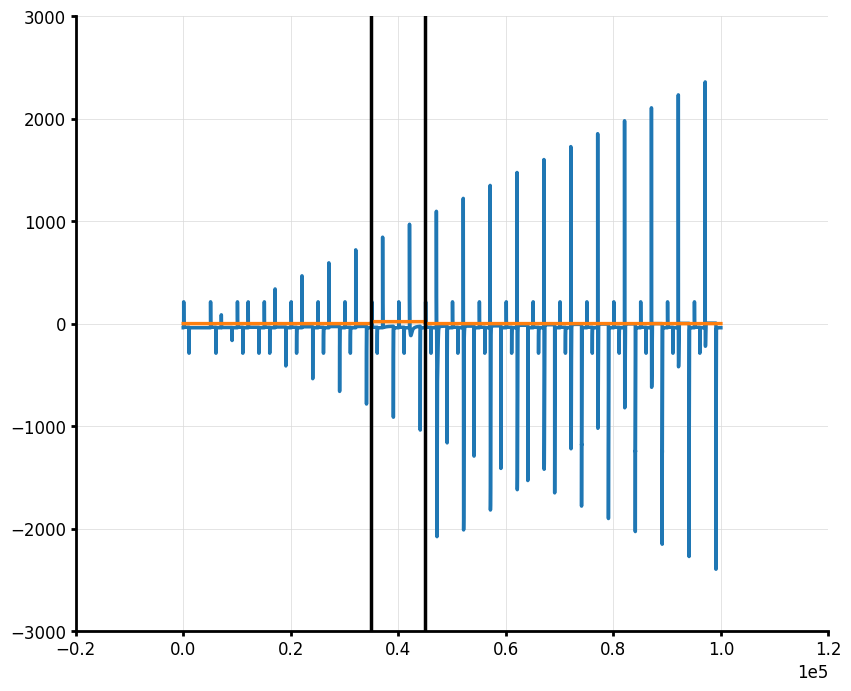

In [6]:
start = int(len(art_data.I_out)*7/20)
end = int(len(art_data.I_out)*9/20)
weight = np.zeros_like(art_data.I_out)
weight+=1
weight[start:end]*= 20
plt.plot(art_data.I_out)
plt.plot(weight)
plt.axvline(start, color = 'k')
plt.axvline(end, color = 'k')


In [7]:
W = pd.DataFrame(np.array([art_data.t.values, weight]).T, columns=['t','w'])
W.to_csv('../../data/sample_weights/weight_20_for_30_and_35_mV.csv')

In [8]:
pd.read_csv('../../data/sample_weights/weight_20_for_30_and_35_mV.csv').w

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
99995    1.0
99996    1.0
99997    1.0
99998    1.0
99999    1.0
Name: w, Length: 100000, dtype: float64